<a href="https://colab.research.google.com/github/angeellogabriel/ICM-IM-Dataset-Lee19-com-LASSO/blob/main/ICM_para_bci_data_Lee19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Importação de Bibliotecas
!pip install mne
import mne
import itertools
import warnings
import numpy as np
import pickle
from time import time
from scipy.fftpack import fft
from scipy.linalg import eigh
from scipy.signal import butter, firwin, lfilter
from sklearn.svm import SVC
from scipy.io import loadmat
from scipy.stats import norm
from sklearn.preprocessing import normalize
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import datasets, layers, models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 14.7 MB/s eta 0:00:00


In [ ]:
# @title Função extração de épocas
def extractEpochs(data, events, smin, smax, class_ids):
    events_list = events[:, 1] # get class labels column
    cond = False
    for i in range(len(class_ids)): cond += (events_list == class_ids[i]) #get only class_ids pos in events_list
    idx = np.where(cond)[0]
    s0 = events[idx, 0] # get initial timestamps of each class epochs
    sBegin = s0 + smin
    sEnd = s0 + smax
    n_epochs = len(sBegin)
    n_channels = data.shape[0]
    n_samples = smax - smin
    epochs = np.zeros([n_epochs, n_channels, n_samples])
    labels = events_list[idx]
    bad_epoch_list = []
    for i in range(n_epochs):
        epoch = data[:, sBegin[i]:sEnd[i]]
        if epoch.shape[1] == n_samples: epochs[i, :, :] = epoch # Check if epoch is complete
        else:
            print('Incomplete epoch detected...', n_samples, '!=', epoch.shape[1])
            bad_epoch_list.append(i)
    labels = np.delete(labels, bad_epoch_list)
    epochs = np.delete(epochs, bad_epoch_list, axis=0)
    return epochs, labels

In [ ]:
# @title Filtragem temporal
class Filter:
    def __init__(self, fl, fh, Fs, filtering, band_type='bandpass'):
        self.ftype = filtering['design']
        if self.ftype != 'DFT':
            nyq = 0.5*Fs
            low = fl/nyq
            high = fh/nyq
            if low == 0: low = 0.001
            if high >= 1: high = 0.99
            if self.ftype == 'IIR':
                # self.b, self.a = iirfilter(filtering['iir_order'], [low, high], btype='band')
                self.b, self.a = butter(filtering['iir_order'], [low, high], btype=band_type)
            elif self.ftype == 'FIR':
                self.b, self.a = firwin(filtering['fir_order'], [low, high], window='hamming', pass_zero=False), [1]

    def apply_filter(self, X, is_epoch=False):
        if self.ftype != 'DFT': XF = lfilter(self.b, self.a, X) # lfilter, filtfilt
        else:
            XF = fft(X)
            if is_epoch:
                real, imag = np.real(XF).T, np.imag(XF).T
                XF = np.transpose(list(itertools.chain.from_iterable(zip(imag, real))))
            else:
                real = np.transpose(np.real(XF), (2, 0, 1))
                imag = np.transpose(np.imag(XF), (2, 0, 1))
                XF = np.transpose(list(itertools.chain.from_iterable(zip(imag, real))), (1, 2, 0))
        return XF

In [ ]:
# @title Filtragem espacial e seleção e extração de características
class CSP:
    def __init__(self, n_components):
        self.n_components = n_components
        self.filters_ = None
    def fit(self, X, t):
        ch = X.shape[1]
        class_ids = np.unique(t)
        X1 = X[class_ids[0] == t]
        X2 = X[class_ids[1] == t]
        S1, S2 = np.zeros((ch, ch)), np.zeros((ch, ch))
        for i in range(len(X1)): S1 += np.dot(X1[i], X1[i].T) / X1[i].shape[-1] # cov X[i]
        for i in range(len(X2)): S2 += np.dot(X2[i], X2[i].T) / X2[i].shape[-1] # ...sum((X*X.T)/q)
        S1 /= len(X1);
        S2 /= len(X2)
        [D, W] = eigh(S1, S1 + S2) # + 1e-10 * np.eye(22))
        ind = np.empty(ch, dtype=int)
        ind[0::2] = np.arange(ch-1, ch//2 - 1, -1)
        ind[1::2] = np.arange(0, ch//2)
        # W += 1e-1 * np.eye(22)
        W = W[:, ind]
        self.filters_ = W.T[:self.n_components]
        return self # used on cross-validation pipeline
    def transform(self, X):
        Y = np.asarray([np.dot(self.filters_, ep) for ep in X])
        # FEAT = np.log(np.mean(Y**2, axis=2))
        FEAT = np.log(np.var(Y, axis=2))
        return FEAT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
suj = 1
eeg = loadmat('/content/drive/MyDrive/BCI/bci_data/Lee19/sess0' + str(suj) + '_subj01_EEG_MI.mat') # Neste arquivo contém tantos os dados de treinamento quando de teste

In [ ]:
eeg_data1 = eeg['EEG_MI_train']['x'][0,0].T
eeg_data2 = eeg['EEG_MI_test']['x'][0,0].T
eeg_events1 = np.r_[eeg['EEG_MI_train']['t'][0,0], eeg['EEG_MI_train']['y_dec'][0,0]].T
eeg_events2 = np.r_[eeg['EEG_MI_test']['t'][0,0], eeg['EEG_MI_test']['y_dec'][0,0]].T

In [ ]:
# FREQUÊNCIA DE AMOSTRAGEM E JANELA DE INTERESSE

Fs = 1000
smin, smax = int(0.0*Fs), int(2.5*Fs)

class_ids = [1,2]

#Parâmetros de Filtragem
fl, fh = 8, 30
ncsp = 8
nbands = 10

<function matplotlib.pyplot.show(close=None, block=None)>

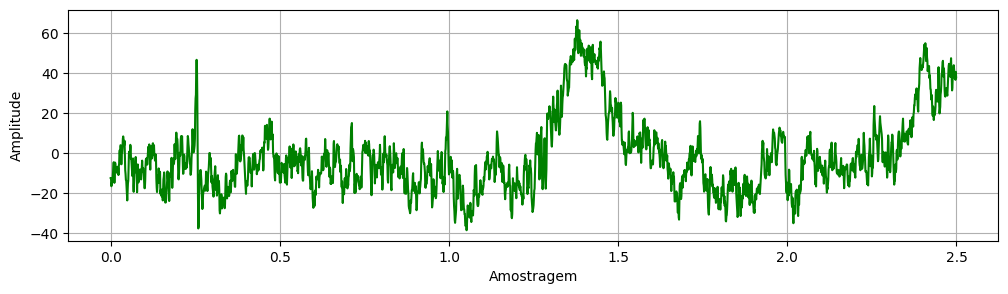

In [ ]:
lb_utils = [1, 2]

ZT, tt = extractEpochs(eeg_data1, eeg_events1, smin, smax, lb_utils)
ZT = np.vstack([ ZT[np.where(tt == k)] for k in class_ids ])
tt = np.hstack([ np.ones(len(ZT)//2)*k for k in class_ids ]).astype(int)

ZV, tv = extractEpochs(eeg_data2, eeg_events2, smin, smax, lb_utils)

ZV = np.vstack([ ZV[np.where(tv == k)] for k in class_ids ])
tv = np.hstack([ np.ones(len(ZV)//2)*k for k in class_ids ]).astype(int)

canal_1 = 32
classe_1 = 45
epoca_1 = (ZT[classe_1, canal_1,:])
tempo = np.linspace(smin  / Fs, smax / Fs, smax - smin, endpoint=False)

plt.figure(figsize=(12, 3))
plt.plot(tempo, epoca_1, 'g')
plt.ylabel('Amplitude')
plt.xlabel('Amostragem')
plt.grid()
plt.show

In [ ]:
ZT.shape

(100, 62, 2500)

In [ ]:
filtering = 'IIR' # DFT ou IIR


#t0 = time()
step = (fh-fl) / (nbands+1) # n_bins/nbands+1
size = step / 0.5 # step/overlap
sub_bands = []
for i in range(nbands):
  fl_sb = i * step + fl
  fh_sb = i * step + size + fl
  sub_bands.append([fl_sb, fh_sb])

## Filtragem temporal
XT, XV = [], []
if filtering == 'DFT':
  filt = Filter(fl, fh, Fs, {'design':'DFT'})
  XTF = filt.apply_filter(ZT)
  XVF = filt.apply_filter(ZV)
  for i in range(nbands):
    bsize = 2/(Fs/ZT.shape[-1]) # 2 == sen/cos
    XT.append(XTF[:, :, round(sub_bands[i][0]*bsize):round(sub_bands[i][1]*bsize)])
    bsize = 2/(Fs/ZV.shape[-1])
    XV.append(XVF[:, :, round(sub_bands[i][0]*bsize):round(sub_bands[i][1]*bsize)])
elif filtering == 'IIR':
  for i in range(nbands):
    filt = Filter(sub_bands[i][0], sub_bands[i][1], Fs, {'design':'IIR', 'iir_order':5})
    XT.append(filt.apply_filter(ZT))
    XV.append(filt.apply_filter(ZV))

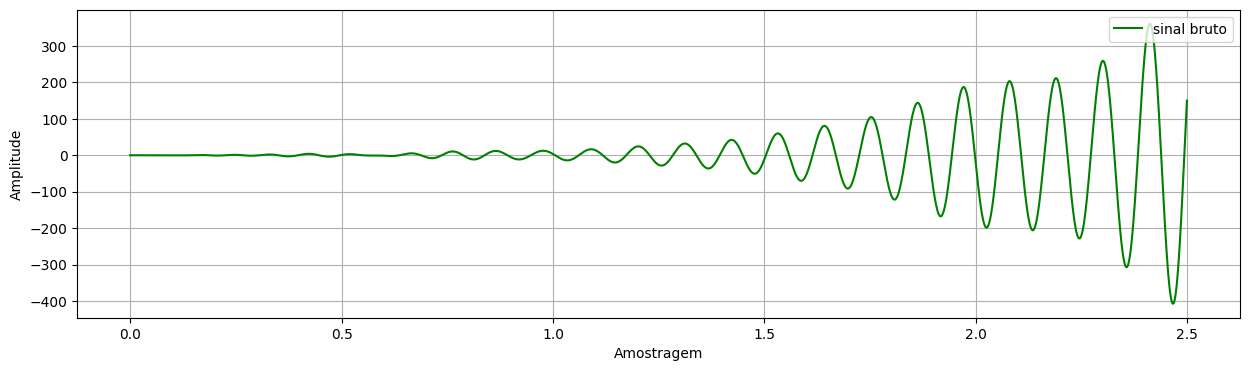

In [ ]:
sinal_filtrado_1 = (XT[0][classe_1][canal_1])

plt.figure(figsize=(15, 4))
plt.plot(tempo, sinal_filtrado_1, 'g', label = 'sinal bruto')
plt.ylabel('Amplitude')
plt.xlabel('Amostragem')
plt.grid()
plt.legend(loc = 'upper right')
plt.show()

In [ ]:
## Filtragem espacial
csp = [CSP(n_components=ncsp) for i in range(nbands)]
for i in range(nbands): csp[i].fit(XT[i], tt)
FT = [ csp[i].transform(XT[i]) for i in range(nbands) ]
FV = [ csp[i].transform(XV[i]) for i in range(nbands) ]

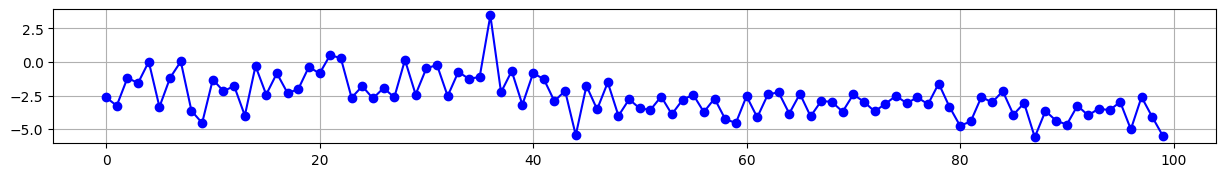

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot(411)
plt.plot(FT[0][:,[0]], '-ob')
plt.grid()
plt.show()

In [ ]:
## Pontuações LDA
ldas = [ LDA() for i in range(nbands) ]
for i in range(nbands): ldas[i].fit(FT[i], tt)
ST = np.asarray([ np.ravel(ldas[i].transform(FT[i])) for i in range(nbands)]).T # Score LDA
SV = np.asarray([ np.ravel(ldas[i].transform(FV[i])) for i in range(nbands)]).T

## FUSÃO DE PONTUAÇÕES
p0 = norm(np.mean(ST[tt == class_ids[0], :], axis=0), np.std(ST[tt == class_ids[0], :], axis=0))
p1 = norm(np.mean(ST[tt == class_ids[1], :], axis=0), np.std(ST[tt == class_ids[1], :], axis=0))
META_ST = np.log(p0.pdf(ST) / p1.pdf(ST))
META_SV = np.log(p0.pdf(SV) / p1.pdf(SV))

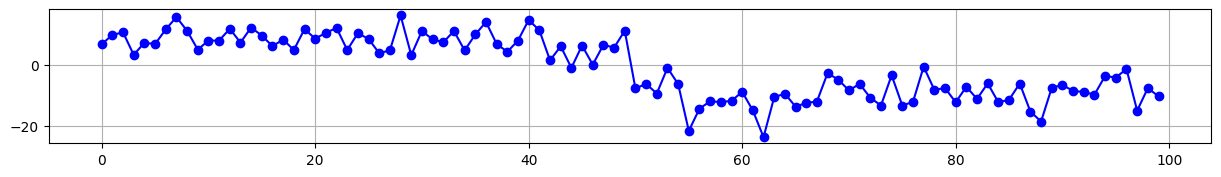

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot(411)
plt.plot(META_ST[:,0], '-ob')
plt.grid()
plt.show()

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
tt_ = 2*tt-3
lasso = Lasso(alpha=0.5)
lasso.fit(META_ST, tt_)
score = lasso.score(META_ST, tt_)
print(score*100,("%"))
#y_ = lasso.predict(META_SV)

#w_ = lasso.coef_
#print(w_)


90.54980817439915 %


In [ ]:
lambdas = [0.0001,0.001,0.01,0.1,0.5,1]
scores = []

for i in range(len(lambdas)):
  modelo = Lasso(alpha=lambdas[i])
  modelo.fit(META_ST, tt_)
  scores.append(score)

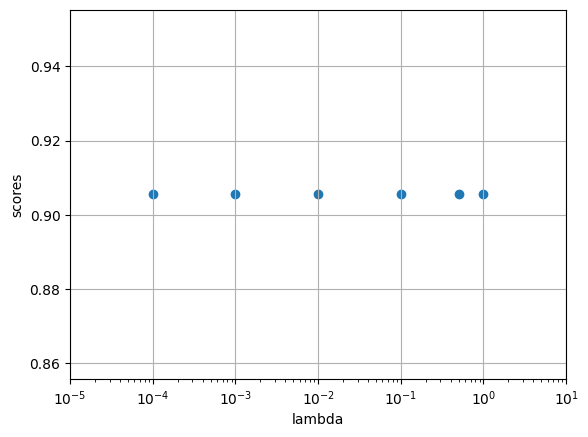

In [ ]:
plt.scatter(lambdas,scores);
plt.xlabel('lambda');
plt.ylabel('scores');
plt.xscale('log');
plt.xlim([1e-5,10]);
plt.grid()

In [ ]:
modelo_final = Lasso(alpha=0.01)
modelo_final.fit(META_ST, tt_)
Y_pred = modelo_final.predict(META_ST)

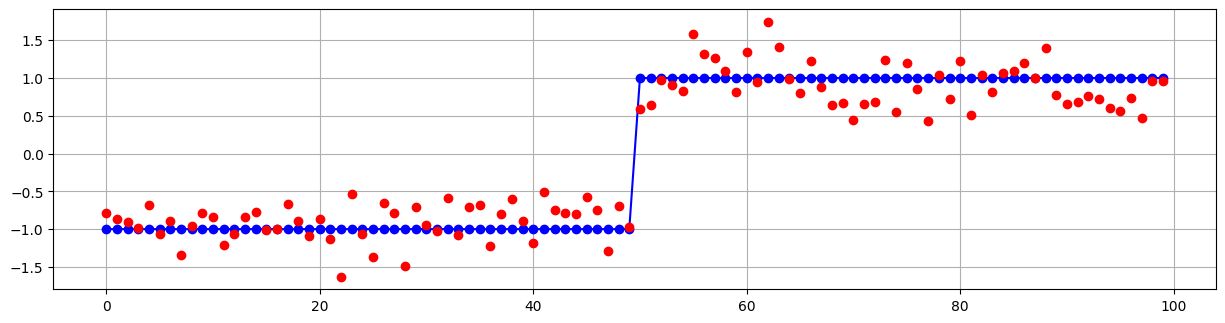

In [ ]:
# @title
plt.figure(figsize=(15,8))
plt.subplot(211)
plt.plot(tt_, '-ob')
plt.plot(Y_pred,'or')
plt.grid()
plt.show()

In [ ]:
# @title
tt_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [ ]:
# @title
Y_pred

array([-0.78574919, -0.87060919, -0.91180484, -0.99048894, -0.67632252,
       -1.0666729 , -0.88969636, -1.33960799, -0.95375062, -0.78220804,
       -0.83676053, -1.20792918, -1.06834176, -0.84175803, -0.7703206 ,
       -1.01258781, -0.9923486 , -0.66337371, -0.89434227, -1.09785152,
       -0.86992271, -1.13555278, -1.6282263 , -0.53500982, -1.06117204,
       -1.36410948, -0.66055714, -0.78318411, -1.48900286, -0.70471776,
       -0.9426589 , -1.02955375, -0.59180939, -1.07528853, -0.70884998,
       -0.67578725, -1.22000881, -0.80069484, -0.60016414, -0.89931469,
       -1.18305085, -0.51352934, -0.74249743, -0.78301384, -0.79664493,
       -0.57077   , -0.74567673, -1.29486486, -0.69534496, -0.97586676,
        0.59415424,  0.64072684,  0.97367259,  0.90802694,  0.82707256,
        1.57616551,  1.31666809,  1.26906414,  1.09006864,  0.82012148,
        1.35063118,  0.94146601,  1.74134484,  1.41425228,  0.98247447,
        0.80061735,  1.22797979,  0.88658419,  0.63897221,  0.67

In [ ]:
w_ = lasso.coef_
w_

array([-0.03637841, -0.04306641, -0.00652884, -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ])

In [ ]:
META_ST.shape
META_ST_ = META_ST[:,[0,1,2]]
META_ST_.shape

(100, 3)

In [ ]:
w_.shape

(10,)

In [ ]:
#Classificação

#SVM

svm = SVC(kernel='linear', C=1e-6, probability=True)
svm.fit(META_ST, tt)
y, yp = svm.predict(META_SV), svm.predict_proba(META_SV);
acc_svm = round(np.mean(y == tv)*100,2) # round(svm.score(META_SV, tv)*100,2)
print('SVM acc:', acc_svm)

#MLP

mlp = MLPClassifier(verbose=False, max_iter=10000, learning_rate_init=10 **(-3), activation='tanh',
                        hidden_layer_sizes=(20,1))
mlp.out_activation = 'softmax' # 'logistic', 'softmax', # mlp.outputs = 3
mlp.fit(META_ST, tt_)
ymlp = mlp.predict(META_SV)
acc_mlp = round(np.mean(ymlp == tv)*100,2) # round(svm.score(META_SV, tv)*100,2)
print('MLP acc:', acc_mlp)

#KNN

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(META_ST,tt_)
yknn = knn.predict(META_SV)
acc_knn = round(np.mean(yknn == tv)*100,2) # round(svm.score(META_SV, tv)*100,2)
print('KNN acc:', acc_knn)

#LDA

lda_clf = LDA()
lda_clf.fit(META_ST,tt_)
ylda = lda_clf.predict(META_SV)
acc_lda = round(np.mean(ylda == tv)*100,2) # round(svm.score(META_SV, tv)*100,2)
print('LDA acc:', acc_lda)

#LR

lr = LogisticRegression(verbose=False)
lr.fit(META_ST,tt)
ylr = lr.predict(META_SV)
acc_lr = round(np.mean(ylr == tv)*100,2) # round(svm.score(META_SV, tv)*100,2)
print('LR acc:', acc_lr)

SVM acc: 48.0
MLP acc: 20.0
KNN acc: 18.0
LDA acc: 19.0
LR acc: 53.0
